In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import pandas as pd
import re
from datetime import datetime

from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from rfpimp import *

import warnings
warnings.filterwarnings("ignore")

## Imports and EDA

In [2]:
df = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
def make_pipelines(n_estimators):
    "Create a single pipeline that processing the data and then fits the regressor." 
        
    numeric_features = ['price']
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scl', StandardScaler())])
    
    numeric_transformer_tree = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    preprocessor = compose.ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
    preprocessor_tree = compose.ColumnTransformer(transformers=[('num', numeric_transformer_tree, numeric_features)])


    
    pipe_lr = Pipeline([('preprocessor', preprocessor), 
                        ('regr', LinearRegression(n_jobs=-1))])
    
    pipe_lasso = Pipeline([('preprocessor', preprocessor),
                           ('regr', Lasso(alpha=0.2))])
    
    pipe_rf = Pipeline([('preprocessor', preprocessor_tree),
                        ('regr', RandomForestRegressor(n_estimators=n_estimators, 
                                                      min_samples_leaf=.1, 
                                                      random_state=42, 
                                                      n_jobs=-1))])

    pipe_xtr = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', ExtraTreesRegressor(n_estimators=n_estimators*5, 
                                                        random_state=42,
                                                        n_jobs=-1))])
    
    pipe_ada = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                                                           min_samples_leaf=.1),
                                                      n_estimators=n_estimators,
                                                      random_state=42))])
    
    pipeline = [pipe_lr, pipe_lasso, pipe_rf, pipe_xtr]
    return pipeline

In [4]:
def evaluate(y_test, y_pred):

    results = {'Median Absolute Error' : round(median_absolute_error(y_test, y_pred), 3),
               'Mean Absolute Error' : round(mean_absolute_error(y_test, y_pred), 3),
               'R-Sq' : round(r2_score(y_test, y_pred), 2),
               'MSE' : round(mean_squared_error(y_test, y_pred),2),
               'Max Error': round(max_error(y_test, y_pred),2)}
                             
    return results

# Baselines before Feature Engineering

In [5]:
X = df[['price']]
y = df['points']

In [6]:
pipelines = make_pipelines(n_estimators=5)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
def pipeline_results(pipelines, X_train, X_test, y_train, y_test):
    models = []
    results_df = pd.DataFrame(columns=['MedAE','MeanAE','R-Squared','MSE','Max Error'])
    
    for p in pipelines:
        print('.',end='')
        p.fit(X_train, y_train)
        models.append(p)

        y_pred = p.predict(X_test)

        metrics = list(evaluate(y_test, y_pred).values())    
        results_df.loc[len(results_df)] = metrics

    results_df = results_df.T
    results_df.columns = ['Linear','Lasso','RF','XT']
    return models, results_df.T

In [9]:
%%time
models, results = pipeline_results(pipelines, X_train, X_test, y_train, y_test)
results

....CPU times: user 1.29 s, sys: 46.6 ms, total: 1.33 s
Wall time: 1.1 s


,MedAE,MeanAE,R-Squared,MSE,Max Error
Linear,1.900,2.229,0.15,7.94,58.63
Lasso,1.938,2.256,0.15,7.96,48.58
RF,1.575,1.992,0.33,6.27,10.48
XT,1.616,1.955,0.36,6.04,10.84


## Adding One Hot Encoding

In [10]:
def make_pipelines_2(n_estimators):
    "Create a single pipeline that processing the data and then fits the regressor." 
        
    numeric_features = ['price']
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scl', StandardScaler())])

    numeric_transformer_tree = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    categorical_features = ['taster_name','country','region_2']
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                              ('hot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = compose.ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                           ('cat', categorical_transformer, categorical_features)])

    preprocessor_tree = compose.ColumnTransformer(transformers=[('num', numeric_transformer_tree, numeric_features),
                                                           ('cat', categorical_transformer, categorical_features)])
    pipe_lr = Pipeline([('preprocessor', preprocessor), 
                        ('regr', LinearRegression(n_jobs=-1))])
    
    pipe_lasso = Pipeline([('preprocessor', preprocessor),
                           ('regr', Lasso(alpha=0.2))])
    
    pipe_rf = Pipeline([('preprocessor', preprocessor_tree),
                        ('regr', RandomForestRegressor(n_estimators=n_estimators, 
                                                      min_samples_leaf=.1, 
                                                      random_state=42, 
                                                      n_jobs=-1))])

    pipe_xtr = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', ExtraTreesRegressor(n_estimators=n_estimators*5, 
                                                        random_state=42,
                                                        n_jobs=-1))])
    
    pipe_ada = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                                                           min_samples_leaf=.1),
                                                      n_estimators=n_estimators,
                                                      random_state=42))])
                                                  
    pipeline = [pipe_lr, pipe_lasso, pipe_rf, pipe_xtr]
    return pipeline

In [11]:
pipelines_2 = make_pipelines_2(5)

In [12]:
X = df[['price','taster_name','country','region_2']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
%%time
models, results = pipeline_results(pipelines_2, X_train, X_test, y_train, y_test)
results

....CPU times: user 1min 48s, sys: 14.7 s, total: 2min 2s
Wall time: 1min 27s


,MedAE,MeanAE,R-Squared,MSE,Max Error
Linear,1.792,2.088,0.25,7.00,54.81
Lasso,1.938,2.256,0.15,7.96,48.58
RF,1.575,1.992,0.33,6.27,10.48
XT,1.500,1.827,0.42,5.42,11.00


## Feature Engineering

### Varieties

In [15]:
# too many columns to add - 707
hot_varieties = pd.get_dummies(df['variety'])
hot_varieties 

,Abouriou,Agiorgitiko,Aglianico,Aidani,Airen,Albana,Albanello,Albariño,Albarossa,Aleatico,...,Yapincak,Zelen,Zibibbo,Zierfandler,Zierfandler-Rotgipfler,Zinfandel,Zlahtina,Zweigelt,Çalkarası,Žilavka
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
hot_varieties.corrwith(df['points']).abs().sort_values(ascending=False)

Pinot Noir                   0.106986
Rosé                         0.088433
Nebbiolo                     0.088123
Riesling                     0.067290
Sauvignon Blanc              0.066725
                               ...   
Merlot-Syrah                 0.000068
Duras                        0.000045
Pinot Bianco                 0.000010
Greco                        0.000009
Malbec-Cabernet Sauvignon    0.000008
Length: 707, dtype: float64

In [17]:
# select only the top 25 by variation
varieties_25 = hot_varieties.corrwith(df['points']).abs().sort_values(ascending=False).head(25).index
df.loc[~df.variety.isin(varieties_25), 'variety'] = np.nan

In [18]:
df.variety

0         White Blend
1                 NaN
2                 NaN
3            Riesling
4          Pinot Noir
             ...     
129966       Riesling
129967     Pinot Noir
129968            NaN
129969            NaN
129970            NaN
Name: variety, Length: 129971, dtype: object

### Parsing Vintage Year

In [19]:
regex = re.compile('[^0-9]')

title_words = [t.split() for t in df.title]  
rem_char_titles = []

for t in title_words:
    no_char_t = []
    for w in t:
        cw = regex.sub('',w)
        if len(cw) == 4:
            no_char_t.append(cw)
            
    rem_char_titles.append(no_char_t)

In [20]:
vintages = []
for i,l in enumerate(rem_char_titles):
    if not l:
        vintages.append(np.nan)
    elif len(l) == 1:
        year = int(l[0])
        if year >= 1900:
            vintages.append(year)
        else:
            vintages.append(1900)
    else:
        l = map(int,l)
        for i in l:
            if i > 1980 and i <= 2017:
                vintages.append(i)
                break
                
vintages = pd.Series(vintages) 

In [21]:
vintages

0         2013.0
1         2011.0
2         2013.0
3         2013.0
4         2012.0
           ...  
129966    2013.0
129967    2004.0
129968    2013.0
129969    2012.0
129970    2012.0
Length: 129971, dtype: float64

In [22]:
vintage_df = pd.DataFrame({'Age' : max(vintages) - vintages}).fillna(vintages.median())
vintage_df['Age Bucket'] = vintage_df['Age'] // 5
vintage_df.loc[vintage_df['Age Bucket'] > 10, 'Age Bucket'] = np.nan
vintage_df

,Age,Age Bucket
0,4.0,0.0
1,6.0,1.0
2,4.0,0.0
3,4.0,0.0
4,5.0,1.0
...,...,...
129966,4.0,0.0
129967,13.0,2.0
129968,4.0,0.0
129969,5.0,1.0


In [23]:
vintage_df['Age Bucket'].value_counts()

1.0     57789
0.0     45211
2.0     18810
3.0      3007
4.0       446
5.0        36
6.0        14
10.0        9
7.0         5
9.0         5
8.0         3
Name: Age Bucket, dtype: int64

### Outlier Removal

In [24]:
scaler = StandardScaler()
z_price = scaler.fit_transform(df.price.fillna(df.price.median()).to_numpy().reshape(-1,1))

In [25]:
z_price = pd.DataFrame({'Z Price' : z_price.flatten()})
z_price.loc[z_price['Z Price'] > 5, 'Z Price'] = 5
z_price.loc[z_price['Z Price'] < -5, 'Z Price'] = -5
z_price

,Z Price
0,-0.243193
1,-0.495310
2,-0.520521
3,-0.545733
4,0.765272
...,...
129966,-0.167559
129967,1.017388
129968,-0.117135
129969,-0.066712


In [26]:
min(z_price['Z Price']), max(z_price['Z Price'])

(-0.7726377396161901, 5.0)

In [27]:
price_inliers = pd.DataFrame({'Price Inliers': scaler.inverse_transform(z_price).flatten()})
price_inliers

,Price Inliers
0,25.0
1,15.0
2,14.0
3,13.0
4,65.0
...,...
129966,28.0
129967,75.0
129968,30.0
129969,32.0


### Vader:  Sentiment Analysis

In [31]:
analyzer = SentimentIntensityAnalyzer()

def analyze_polarity(col):
    polarity = {'Negative Sentiment':[], 'Neutral Sentiment':[], 'Positive Sentiment':[], 'Compound Sentiment':[]}
    for i in col:
        scores = analyzer.polarity_scores(i)
        polarity['Negative Sentiment'].append(scores['neg'])
        polarity['Neutral Sentiment'].append(scores['neu'])
        polarity['Positive Sentiment'].append(scores['pos'])
        polarity['Compound Sentiment'].append(scores['compound'])
    return polarity

In [32]:
%%time
sentiments = analyze_polarity(df.description)

CPU times: user 1min 32s, sys: 754 ms, total: 1min 32s
Wall time: 1min 39s


In [33]:
sentiments = pd.DataFrame(sentiments)
sentiments.tail(3)

,Negative Sentiment,Neutral Sentiment,Positive Sentiment,Compound Sentiment
129968,0.072,0.865,0.063,0.1548
129969,0.000,0.891,0.109,0.5267
129970,0.047,0.723,0.230,0.7003


### Description Adjectives

In [34]:
adjectives =  ['fruit', 'strong', 'tangy', 'bitter', 'alcohol', 
               'floral', 'acidity', 'tobacco','tannin', 'ripe', 
               'spice', 'oak', 'rich', 'dry', 'crisp', 'sweet', 
               'vanilla', 'full', 'tropical', 'strong', 'bitter']

In [35]:
dfc = df[['description']].copy()
dfc['Descriptive Adj'] = np.nan
for adj in adjectives:
    dfc.loc[dfc.description.str.contains(adj), 'Descriptive Adj'] = adj

In [36]:
dfc['Descriptive Adj'].value_counts()

full        16814
sweet       10707
dry          9956
crisp        9145
rich         9083
spice        8652
vanilla      8217
fruit        7900
tannin       7415
ripe         7187
oak          7102
acidity      5391
bitter       4294
tropical     3384
strong       3381
tobacco       716
floral        636
tangy         504
alcohol       426
Name: Descriptive Adj, dtype: int64

In [37]:
descriptive_adj_df = dfc[['Descriptive Adj']]
descriptive_adj_df

,Descriptive Adj
0,tropical
1,ripe
2,crisp
3,dry
4,NaN
...,...
129966,sweet
129967,full
129968,crisp
129969,crisp


### Added the extra features...
- varieties one hot
- vintage year numeric column
- vintage 5 year bucket categorical column
- outlier removed prices at 5 sigmas
- vader sentiment numeric columns
- adjectives one hot

In [38]:
def make_pipelines_3(n_estimators):
    "Create a single pipeline that processing the data and then fits the regressor." 
        
    numeric_features = ['Age','Negative Sentiment','Neutral Sentiment','Positive Sentiment',
                        'Compound Sentiment','Price Inliers']
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('scl', StandardScaler())])
    
    numeric_transformer_tree = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    categorical_features = ['Taster','Country','Subregion','Wine Variety','Age Bucket','Descriptive Adj']
    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                              ('hot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = compose.ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                           ('cat', categorical_transformer, categorical_features)])
    
    preprocessor_tree = compose.ColumnTransformer(transformers=[('num', numeric_transformer_tree, numeric_features),
                                                                ('cat', categorical_transformer, categorical_features)])
    
    
    pipe_lr = Pipeline([('preprocessor', preprocessor), 
                        ('regr', LinearRegression(n_jobs=-1))])
    
    pipe_lasso = Pipeline([('preprocessor', preprocessor),
                           ('regr', Lasso(alpha=0.2))])
    
    pipe_rf = Pipeline([('preprocessor', preprocessor_tree),
                        ('regr', RandomForestRegressor(n_estimators=n_estimators, 
                                                      min_samples_leaf=.1, 
                                                      random_state=42, 
                                                      n_jobs=-1))])

    pipe_xtr = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', ExtraTreesRegressor(n_estimators=n_estimators*5, 
                                                        random_state=42,
                                                        n_jobs=-1))])
    
    pipe_ada = Pipeline([('preprocessor', preprocessor_tree),
                           ('regr', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3,
                                                                                           min_samples_leaf=.1),
                                                      n_estimators=n_estimators,
                                                      random_state=42))])
    
    pipeline = [pipe_lr, pipe_lasso, pipe_rf, pipe_xtr]
    return pipeline

In [39]:
df_temp = df[['taster_name','country','region_2','variety']]
df_temp.columns = ['Taster','Country','Subregion','Wine Variety']

In [40]:
X_fe = pd.concat([df_temp, vintage_df, descriptive_adj_df, price_inliers, sentiments], axis=1)

In [41]:
X_train_fe, X_test_fe, y_train, y_test = train_test_split(X_fe, y, test_size=0.20, random_state=42)

In [42]:
X_train_fe

,Taster,Country,Subregion,Wine Variety,Age,Age Bucket,Descriptive Adj,Price Inliers,Negative Sentiment,Neutral Sentiment,Positive Sentiment,Compound Sentiment
104748,Virginie Boone,US,Sonoma,Zinfandel,3.0,0.0,acidity,23.0,0.000,0.755,0.245,0.7783
101219,NaN,US,Sonoma,Syrah,12.0,2.0,dry,25.0,0.000,0.882,0.118,0.5574
82261,Virginie Boone,US,Napa,NaN,5.0,1.0,ripe,225.0,0.000,0.898,0.102,0.5719
36717,Roger Voss,Austria,NaN,NaN,11.0,2.0,spice,12.0,0.000,0.927,0.073,0.3182
128031,Roger Voss,France,NaN,Bordeaux-style Red Blend,6.0,1.0,rich,23.0,0.000,0.793,0.207,0.8225
...,...,...,...,...,...,...,...,...,...,...,...,...
128106,Anna Lee C. Iijima,Germany,NaN,Riesling,3.0,0.0,dry,16.0,0.000,0.816,0.184,0.6597
103694,Kerin O’Keefe,Italy,NaN,NaN,3.0,0.0,crisp,30.0,0.053,0.875,0.072,0.2023
860,Matt Kettmann,US,South Coast,NaN,8.0,1.0,strong,45.0,0.000,0.896,0.104,0.6808
15795,Matt Kettmann,US,Central Coast,Bordeaux-style Red Blend,7.0,1.0,vanilla,150.0,0.000,0.943,0.057,0.5346


In [43]:
pipelines_3 = make_pipelines_3(5)

In [44]:
%%time
models, results = pipeline_results(pipelines_3, X_train_fe, X_test_fe, y_train, y_test)
results

....CPU times: user 18min 15s, sys: 19.7 s, total: 18min 35s
Wall time: 6min 43s


,MedAE,MeanAE,R-Squared,MSE,Max Error
Linear,1.515,1.798,0.46,5.11,11.55
Lasso,1.746,2.030,0.33,6.32,12.57
RF,1.794,1.944,0.36,5.99,9.99
XT,1.120,1.432,0.59,3.82,11.56


## Model Selection

In [45]:
m = models[3]

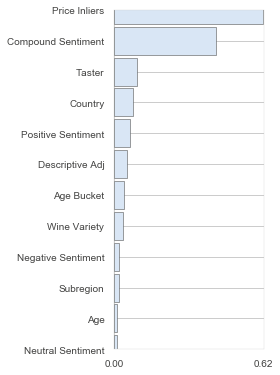

In [51]:
imp = importances(m, X_test_fe, y_test)
viz = plot_importances(imp, vscale=2)
viz.view()

In [54]:
imp.head(15)

,Importance
Feature,
Price Inliers,0.617890
Compound Sentiment,0.421652
Taster,0.092653
Country,0.078981
Positive Sentiment,0.063863
Descriptive Adj,0.050853
Age Bucket,0.038623
Wine Variety,0.035455
Negative Sentiment,0.020972


## Hyperparameter Tuning

In [88]:
grid_params = dict(regr__n_estimators=[5,15,25])#,
                   #regr__max_depth=range(1, 5))

rs = RandomizedSearchCV(pipelines_3[3],  
                      grid_params,
                      n_iter=2,
                      scoring=make_scorer(median_absolute_error),
                      cv=3,
                      n_jobs=-1,
                      verbose=3)

In [89]:
rs.fit(X_fe, y)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  4.5min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 16.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indicator=False,
                                                                     

In [90]:
rs.best_score_

1.2000000000000028

In [91]:
rs.best_params_

{'regr__n_estimators': 5}

In [92]:
rs.best_estimator_

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             